In [18]:
# ----------------------------------------------------------
# Step 0 – Imports, File Paths, and Script Path Setup
# ----------------------------------------------------------

# Core Libraries
import os
import pandas as pd
import geopandas as gpd
import numpy as np

# Visualisation Libraries
import matplotlib.pyplot as plt
import contextily as ctx

# Suppress Warnings
import warnings
warnings.filterwarnings("ignore")

# ----------------------------------------------------------
# File Path Setup
# ----------------------------------------------------------

# Base directory structure
base_dir = "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand"
data_dir = os.path.join(base_dir, "data")
processed_dir = os.path.join(data_dir, "processed")
raw_dir = os.path.join(data_dir, "raw")

# Explicit modality input folder (corrected with full path)
modality_dir = "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/data/raw/modality_modelling"

# Input file paths
lsoa_gpkg_path = os.path.join(processed_dir, "LSOA_CT_Demand_with_Demographics_2024_v1.gpkg")

# CDC file has extra space after the underscore
cdc_path = os.path.join(modality_dir, "NHS_SW_ Community_Diagnostic_Centres_Capability.csv")

# Acute hospital capability file
acute_path = os.path.join(modality_dir, "NHS_SW_Acute_Hospitals_Capability.csv")

# LSOA–LSOA travel time matrix
travel_matrix_path = os.path.join(raw_dir, "LSOA_to_LSOA_complete.csv")


In [19]:
# LSOA-level demand & demographic GeoDataFrame
gdf_lsoa = gpd.read_file(lsoa_gpkg_path)

# Facility capability tables (CDC & Acute)
df_cdc = pd.read_csv(cdc_path)
df_acute = pd.read_csv(acute_path)

# Travel time matrix
df_travel = pd.read_csv(travel_matrix_path)


In [20]:
# Shapes
print("LSOA GeoData:", gdf_lsoa.shape)
print("CDC Sites:", df_cdc.shape)
print("Acute Sites:", df_acute.shape)
print("Travel Matrix:", df_travel.shape)

# Sample columns and rows
print("\nLSOA columns:\n", gdf_lsoa.columns[:10].to_list())
print("\nTravel matrix columns:\n", df_travel.columns.to_list())
print("\nSample travel matrix:\n", df_travel.head())

# Check CRS (should be WGS84 for any visual checks)
print("\nGeo CRS:", gdf_lsoa.crs)
gdf_lsoa = gdf_lsoa.to_crs(epsg=4326)


LSOA GeoData: (3451, 51)
CDC Sites: (24, 22)
Acute Sites: (18, 23)
Travel Matrix: (11003925, 5)

LSOA columns:
 ['ICB23NM', 'ladnm', 'ladcd', 'msoa21nm', 'msoa21cd', 'lsoa21nmw', 'lsoa21cd', 'total_population', 'age_0_4', 'age_5_9']

Travel matrix columns:
 ['origin_name', 'destination_name', 'travel_time_car', 'travel_time_pt_peak', 'travel_time_pt_nonpeak']

Sample travel matrix:
   origin_name destination_name  travel_time_car  travel_time_pt_peak  \
0   E01022150        E01014950        42.748168            56.288168   
1   E01029238        E01033364        85.033922           126.483922   
2   E01014654        E01015202       123.315531           148.025531   
3   E01015028        E01029066       133.568645           268.518645   
4   E01015316        E01029066       112.233260           221.623260   

   travel_time_pt_nonpeak  
0               56.288168  
1              126.483922  
2              146.985531  
3              255.878645  
4              227.623260  

Geo CRS: EPS

In [41]:
# ----------------------------------------------------------
# Step 1 – Filter Valid CT Scanner Locations (with Type Tag)
# ----------------------------------------------------------

# Load raw site capability files
df_cdc = pd.read_csv(cdc_path)
df_acute = pd.read_csv(acute_path)

# Confirm successful load
print(f"Loaded CDC data with {df_cdc.shape[0]} rows")
print(f"Loaded Acute data with {df_acute.shape[0]} rows\n")

# Preview both datasets
print("CDC sample:")
display(df_cdc.head(2))

print("\nAcute sample:")
display(df_acute.head(2))

# Ensure both datasets contain the required 'CT Scanners' column
assert 'CT Scanners' in df_cdc.columns, "'CT Scanners' column missing in CDC file"
assert 'CT Scanners' in df_acute.columns, "'CT Scanners' column missing in Acute file"

# Add facility type column
df_cdc['site_type'] = 'CDC'
df_acute['site_type'] = 'Acute'

# Concatenate into a unified provider dataframe
df_sites = pd.concat([df_cdc, df_acute], axis=0, ignore_index=True)

# Filter: only sites with >0 CT scanners and valid LSOA codes
df_sites = df_sites[df_sites['CT Scanners'].fillna(0) > 0].copy()
df_sites = df_sites[df_sites['lsoa21cd'].notna()].copy()

# Output summary
print(f"\nCT-enabled sites after filtering: {df_sites.shape[0]}")
print("Sample of CT-enabled site LSOA codes:")
print(df_sites['lsoa21cd'].drop_duplicates().head())


Loaded CDC data with 24 rows
Loaded Acute data with 18 rows

CDC sample:


,Code,Name,CT Scanners,MRI Scanners,Endoscopy Rooms,Address 1,Address 2,Address 3,Address 4,Address 5,...,Parent Organisation Code,Parent Organisation Name,postcode,latitude,longitude,lsoa21cd,msoa21cd,oa21cd,icb_code,local_authority
0,B4B4S,Bsw Banes Locality CDC,1,1,3,Foxcote Avenue,Bath Business Park,Peasedown St. John,Bath,NaN,...,QOX,"NHS Bath and North East Somerset, Swindon and ...",BA28SQ,-2.416516,51.311327,E01014444,E02003006,E00072943,E54000040,E06000022
1,K1W4U,Salisbury CDC,1,1,0,Avon Approach,NaN,NaN,Salisbury,NaN,...,QOX,"NHS Bath and North East Somerset, Swindon and ...",SP13SL,-1.797518,51.071737,E01032014,E02006671,E00163295,E54000040,E06000054



Acute sample:


,Code,Trust Name,Name,CT Scanners,MRI Scanners,Endoscopy Rooms,Address 1,Address 2,Address 3,Address 4,...,Parent Organisation Code,Parent Organisation Name,postcode,latitude,longitude,lsoa21cd,msoa21cd,oa21cd,icb_code,local_authority
0,RTE01,Gloucestershire Hospitals NHS Foundation Trust,Cheltenham General Hospital,2,2,2,Sandford Road,NaN,NaN,Cheltenham,...,QR1,NHS Gloucestershire Integrated Care Board,GL537AN,-2.071883,51.892120,E01022116,E02004608,E00168922,E54000043,E07000078
1,RTE03,Gloucestershire Hospitals NHS Foundation Trust,Gloucestershire Royal Hospital,4,2,2,Great Western Road,NaN,NaN,Gloucester,...,QR1,NHS Gloucestershire Integrated Care Board,GL13NN,-2.232073,51.866379,E01022312,E02004637,E00168979,E54000043,E07000081



CT-enabled sites after filtering: 36
Sample of CT-enabled site LSOA codes:
0    E01014444
1    E01032014
2    E01015569
3    E01014833
4    E01014861
Name: lsoa21cd, dtype: object


In [22]:
# ----------------------------------------------------------
# Step 2 – Link CT Scanner Sites to LSOAs
# ----------------------------------------------------------

# Extract unique LSOA codes where at least one CT scanner is present
ct_enabled_lsoas = df_sites['lsoa21cd'].dropna().unique().tolist()

# Check how many destination LSOAs we are working with
print(f"Total unique destination LSOAs with CT scanners: {len(ct_enabled_lsoas)}")

# Optional: Preview the first few
print("Sample of CT-enabled destination LSOA codes:")
print(ct_enabled_lsoas[:5])

# Sanity check: Are all LSOAs in expected format?
assert all(code.startswith("E01") for code in ct_enabled_lsoas), "Unexpected LSOA code format found"

# Confirm that these codes exist in the travel time matrix destination column
# This check will be repeated in Step 3, but can be validated now


Total unique destination LSOAs with CT scanners: 34
Sample of CT-enabled destination LSOA codes:
['E01014444', 'E01032014', 'E01015569', 'E01014833', 'E01014861']


In [23]:
# ----------------------------------------------------------
# Step 3 – Merge Travel Time Matrix
# ----------------------------------------------------------

# Load travel time matrix
df_travel = pd.read_csv(travel_matrix_path)

# Confirm load and inspect
print(f"Loaded travel time matrix with {df_travel.shape[0]} rows")
print("Travel matrix sample:")
display(df_travel.head(2))

# Ensure required columns are present
expected_cols = ['origin_name', 'destination_name', 'travel_time_car', 'travel_time_pt_peak', 'travel_time_pt_nonpeak']
missing_cols = [col for col in expected_cols if col not in df_travel.columns]
assert not missing_cols, f"Missing columns in travel matrix: {missing_cols}"

# Filter travel matrix to:
# 1. Origins that exist in gdf_lsoa
# 2. Destinations that are CT-enabled LSOAs
valid_origins = gdf_lsoa['lsoa21cd'].unique().tolist()
df_travel_filtered = df_travel[
    (df_travel['origin_name'].isin(valid_origins)) &
    (df_travel['destination_name'].isin(ct_enabled_lsoas))
].copy()

# Drop rows with missing travel times (conservative approach)
df_travel_filtered.dropna(subset=['travel_time_car', 'travel_time_pt_peak', 'travel_time_pt_nonpeak'], inplace=True)

# Final confirmation
print(f"\nFiltered travel matrix shape: {df_travel_filtered.shape}")
print("Sample of filtered travel matrix:")
display(df_travel_filtered.head(2))

# Optional sanity check
assert df_travel_filtered['origin_name'].nunique() <= len(valid_origins), "Unexpected origin LSOAs"
assert df_travel_filtered['destination_name'].nunique() <= len(ct_enabled_lsoas), "Unexpected destination LSOAs"


Loaded travel time matrix with 11003925 rows
Travel matrix sample:


,origin_name,destination_name,travel_time_car,travel_time_pt_peak,travel_time_pt_nonpeak
0,E01022150,E01014950,42.748168,56.288168,56.288168
1,E01029238,E01033364,85.033922,126.483922,126.483922



Filtered travel matrix shape: (90857, 5)
Sample of filtered travel matrix:


,origin_name,destination_name,travel_time_car,travel_time_pt_peak,travel_time_pt_nonpeak
229,E01022266,E01015569,68.827676,126.167676,122.537676
289,E01022267,E01015569,71.650230,139.380230,139.380230


In [24]:
# ----------------------------------------------------------
# Step 4 – Apply Cumulative Opportunity Logic (Car Travel Only)
# ----------------------------------------------------------

# Define car travel time bands for each origin LSOA
df_car = df_travel_filtered[['origin_name', 'destination_name', 'travel_time_car']].copy()
df_car.rename(columns={'travel_time_car': 'travel_time_mins'}, inplace=True)

# Create subsets by travel time thresholds
lt_20 = df_car[df_car['travel_time_mins'] < 20].copy()
btw_20_40 = df_car[(df_car['travel_time_mins'] >= 20) & (df_car['travel_time_mins'] <= 40)].copy()
gt_40 = df_car[df_car['travel_time_mins'] > 40].copy()

# Count number of CT scanner sites reachable per origin in each band
ct_access_car_lt_20 = lt_20.groupby('origin_name').size().rename("ct_access_car_lt_20")
ct_access_car_20_40 = btw_20_40.groupby('origin_name').size().rename("ct_access_car_20_40")
ct_access_car_gt_40 = gt_40.groupby('origin_name').size().rename("ct_access_car_gt_40")

# Merge into single DataFrame
df_car_access = (
    pd.DataFrame(index=gdf_lsoa['lsoa21cd'])
    .join(ct_access_car_lt_20)
    .join(ct_access_car_20_40)
    .join(ct_access_car_gt_40)
    .fillna(0)
    .astype(int)
)

# Reset index to merge later
df_car_access = df_car_access.reset_index().rename(columns={'lsoa21cd': 'origin_name'})

# Preview
print("Cumulative CT accessibility by car travel time bands:")
display(df_car_access.head())


Cumulative CT accessibility by car travel time bands:


,origin_name,ct_access_car_lt_20,ct_access_car_20_40,ct_access_car_gt_40
0,E01020484,0,0,27
1,E01020481,0,0,27
2,E01020482,0,0,27
3,E01020479,0,0,27
4,E01020478,0,0,27


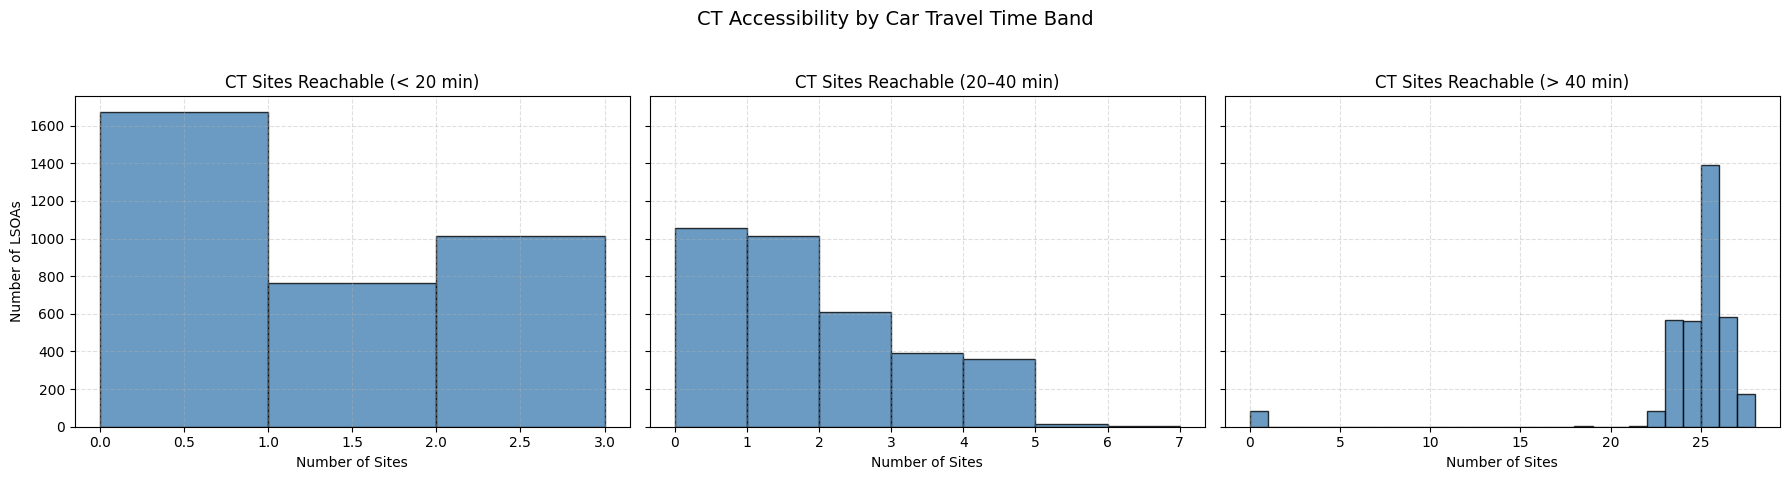

In [29]:
# ----------------------------------------------------------
# Histograms of CT Accessibility by Car Travel Time Band (Separate Plots)
# ----------------------------------------------------------

# Set column names for plotting
access_cols = {
    'ct_access_car_lt_20': '< 20 min',
    'ct_access_car_20_40': '20–40 min',
    'ct_access_car_gt_40': '> 40 min'
}

# Create figure and axes
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5), sharey=True)

# Loop through each band and plot separately
for ax, (col, label) in zip(axes, access_cols.items()):
    max_val = df_car_access[col].max()
    bins = range(0, int(max_val) + 2)
    
    ax.hist(df_car_access[col], bins=bins, color='steelblue', edgecolor='black', alpha=0.8)
    ax.set_title(f"CT Sites Reachable ({label})")
    ax.set_xlabel("Number of Sites")
    ax.grid(True, linestyle='--', alpha=0.4)

axes[0].set_ylabel("Number of LSOAs")

plt.suptitle("CT Accessibility by Car Travel Time Band", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Cumulative CT accessibility by PT peak travel time bands:


,origin_name,ct_access_pt_peak_lt_20,ct_access_pt_peak_20_40,ct_access_pt_peak_gt_40
0,E01020484,0,0,27
1,E01020481,0,0,27
2,E01020482,0,0,27
3,E01020479,0,0,27
4,E01020478,0,0,27


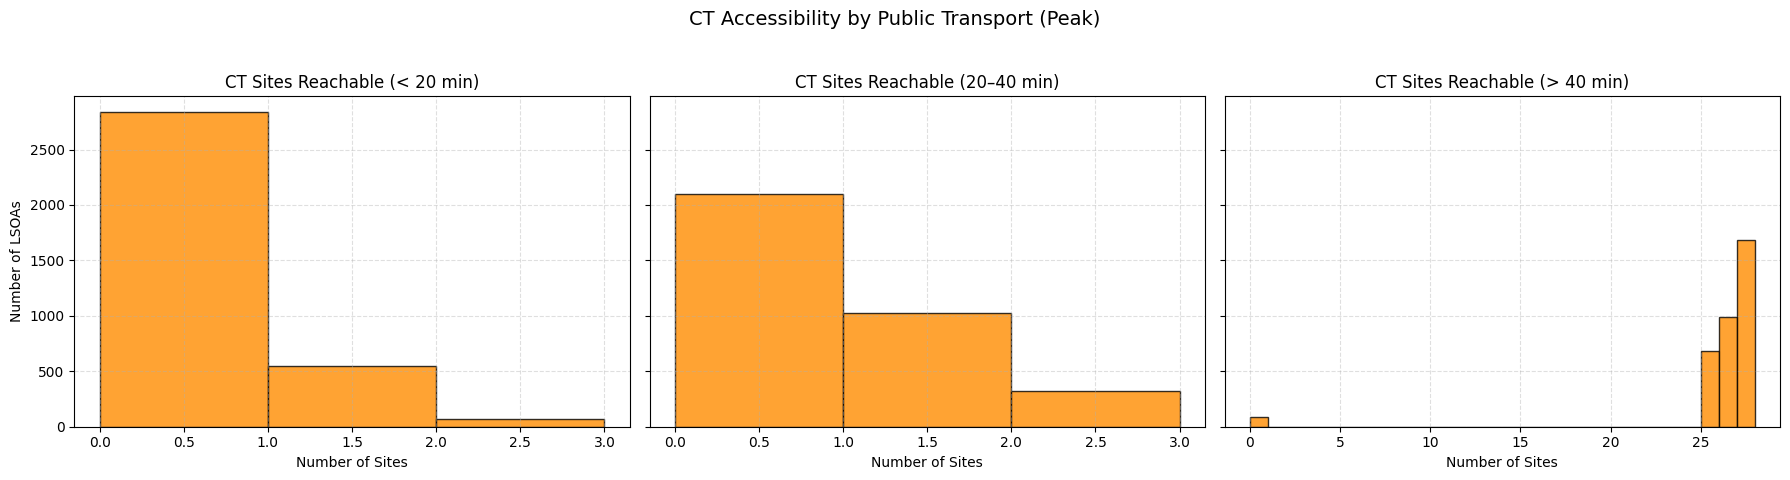

In [30]:
# ----------------------------------------------------------
# Step 4 – Apply Cumulative Opportunity Logic (Public Transport – Peak)
# ----------------------------------------------------------

df_pt_peak = df_travel_filtered[['origin_name', 'destination_name', 'travel_time_pt_peak']].copy()
df_pt_peak.rename(columns={'travel_time_pt_peak': 'travel_time_mins'}, inplace=True)

# Travel time bands
lt_20 = df_pt_peak[df_pt_peak['travel_time_mins'] < 20].copy()
btw_20_40 = df_pt_peak[(df_pt_peak['travel_time_mins'] >= 20) & (df_pt_peak['travel_time_mins'] <= 40)].copy()
gt_40 = df_pt_peak[df_pt_peak['travel_time_mins'] > 40].copy()

# Counts per band
ct_access_pt_peak_lt_20 = lt_20.groupby('origin_name').size().rename("ct_access_pt_peak_lt_20")
ct_access_pt_peak_20_40 = btw_20_40.groupby('origin_name').size().rename("ct_access_pt_peak_20_40")
ct_access_pt_peak_gt_40 = gt_40.groupby('origin_name').size().rename("ct_access_pt_peak_gt_40")

# Combine into DataFrame
df_pt_peak_access = (
    pd.DataFrame(index=gdf_lsoa['lsoa21cd'])
    .join(ct_access_pt_peak_lt_20)
    .join(ct_access_pt_peak_20_40)
    .join(ct_access_pt_peak_gt_40)
    .fillna(0)
    .astype(int)
).reset_index().rename(columns={'lsoa21cd': 'origin_name'})

# Preview
print("Cumulative CT accessibility by PT peak travel time bands:")
display(df_pt_peak_access.head())

# ----------------------------------------------------------
# Histograms of CT Accessibility by PT Peak Travel Time Band
# ----------------------------------------------------------

access_cols_peak = {
    'ct_access_pt_peak_lt_20': '< 20 min',
    'ct_access_pt_peak_20_40': '20–40 min',
    'ct_access_pt_peak_gt_40': '> 40 min'
}

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5), sharey=True)

for ax, (col, label) in zip(axes, access_cols_peak.items()):
    max_val = df_pt_peak_access[col].max()
    bins = range(0, int(max_val) + 2)
    
    ax.hist(df_pt_peak_access[col], bins=bins, color='darkorange', edgecolor='black', alpha=0.8)
    ax.set_title(f"CT Sites Reachable ({label})")
    ax.set_xlabel("Number of Sites")
    ax.grid(True, linestyle='--', alpha=0.4)

axes[0].set_ylabel("Number of LSOAs")
plt.suptitle("CT Accessibility by Public Transport (Peak)", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Cumulative CT accessibility by PT non-peak travel time bands:


,origin_name,ct_access_pt_nonpeak_lt_20,ct_access_pt_nonpeak_20_40,ct_access_pt_nonpeak_gt_40
0,E01020484,0,0,27
1,E01020481,0,0,27
2,E01020482,0,0,27
3,E01020479,0,0,27
4,E01020478,0,0,27


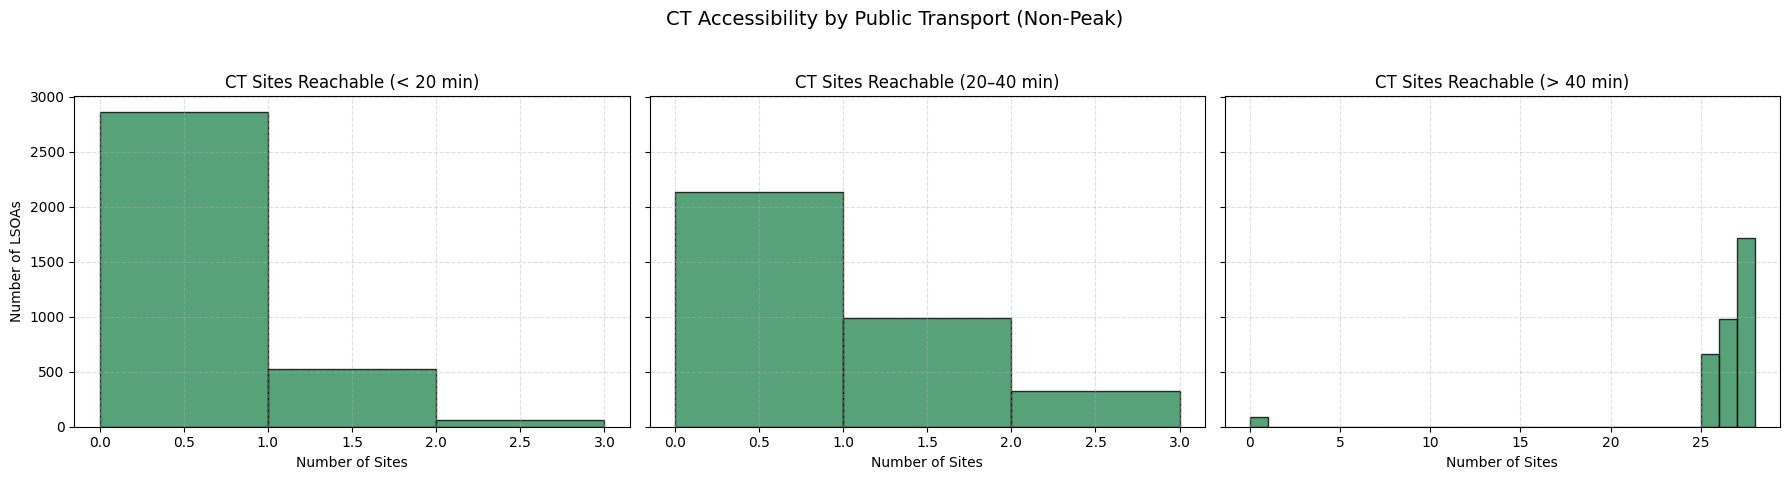

In [31]:
# ----------------------------------------------------------
# Step 4 – Apply Cumulative Opportunity Logic (Public Transport – Non-Peak)
# ----------------------------------------------------------

df_pt_nonpeak = df_travel_filtered[['origin_name', 'destination_name', 'travel_time_pt_nonpeak']].copy()
df_pt_nonpeak.rename(columns={'travel_time_pt_nonpeak': 'travel_time_mins'}, inplace=True)

# Travel time bands
lt_20 = df_pt_nonpeak[df_pt_nonpeak['travel_time_mins'] < 20].copy()
btw_20_40 = df_pt_nonpeak[(df_pt_nonpeak['travel_time_mins'] >= 20) & (df_pt_nonpeak['travel_time_mins'] <= 40)].copy()
gt_40 = df_pt_nonpeak[df_pt_nonpeak['travel_time_mins'] > 40].copy()

# Counts per band
ct_access_pt_nonpeak_lt_20 = lt_20.groupby('origin_name').size().rename("ct_access_pt_nonpeak_lt_20")
ct_access_pt_nonpeak_20_40 = btw_20_40.groupby('origin_name').size().rename("ct_access_pt_nonpeak_20_40")
ct_access_pt_nonpeak_gt_40 = gt_40.groupby('origin_name').size().rename("ct_access_pt_nonpeak_gt_40")

# Combine into DataFrame
df_pt_nonpeak_access = (
    pd.DataFrame(index=gdf_lsoa['lsoa21cd'])
    .join(ct_access_pt_nonpeak_lt_20)
    .join(ct_access_pt_nonpeak_20_40)
    .join(ct_access_pt_nonpeak_gt_40)
    .fillna(0)
    .astype(int)
).reset_index().rename(columns={'lsoa21cd': 'origin_name'})

# Preview
print("Cumulative CT accessibility by PT non-peak travel time bands:")
display(df_pt_nonpeak_access.head())

# ----------------------------------------------------------
# Histograms of CT Accessibility by PT Non-Peak Travel Time Band
# ----------------------------------------------------------

access_cols_nonpeak = {
    'ct_access_pt_nonpeak_lt_20': '< 20 min',
    'ct_access_pt_nonpeak_20_40': '20–40 min',
    'ct_access_pt_nonpeak_gt_40': '> 40 min'
}

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5), sharey=True)

for ax, (col, label) in zip(axes, access_cols_nonpeak.items()):
    max_val = df_pt_nonpeak_access[col].max()
    bins = range(0, int(max_val) + 2)
    
    ax.hist(df_pt_nonpeak_access[col], bins=bins, color='seagreen', edgecolor='black', alpha=0.8)
    ax.set_title(f"CT Sites Reachable ({label})")
    ax.set_xlabel("Number of Sites")
    ax.grid(True, linestyle='--', alpha=0.4)

axes[0].set_ylabel("Number of LSOAs")
plt.suptitle("CT Accessibility by Public Transport (Non-Peak)", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [32]:
# ----------------------------------------------------------
# Step 5 – Merge Accessibility Scores Back to LSOA GeoData
# ----------------------------------------------------------

# Merge all accessibility dataframes on origin_name
df_access_all = (
    df_car_access
    .merge(df_pt_peak_access, on='origin_name', how='outer')
    .merge(df_pt_nonpeak_access, on='origin_name', how='outer')
)

# Confirm merged shape and preview
print(f"Merged accessibility dataframe shape: {df_access_all.shape}")
display(df_access_all.head())

# Merge into gdf_lsoa (join origin_name to lsoa21cd)
gdf_lsoa = gdf_lsoa.merge(df_access_all, how='left', left_on='lsoa21cd', right_on='origin_name')

# Final confirmation
print(f"Updated GeoDataFrame shape: {gdf_lsoa.shape}")
print("Sample of merged columns:")
display(gdf_lsoa[
    ['lsoa21cd', 'ct_access_car_lt_20', 'ct_access_pt_peak_20_40', 'ct_access_pt_nonpeak_gt_40']
].head())


Merged accessibility dataframe shape: (3451, 10)


,origin_name,ct_access_car_lt_20,ct_access_car_20_40,ct_access_car_gt_40,ct_access_pt_peak_lt_20,ct_access_pt_peak_20_40,ct_access_pt_peak_gt_40,ct_access_pt_nonpeak_lt_20,ct_access_pt_nonpeak_20_40,ct_access_pt_nonpeak_gt_40
0,E01020484,0,0,27,0,0,27,0,0,27
1,E01020481,0,0,27,0,0,27,0,0,27
2,E01020482,0,0,27,0,0,27,0,0,27
3,E01020479,0,0,27,0,0,27,0,0,27
4,E01020478,0,0,27,0,0,27,0,0,27


Updated GeoDataFrame shape: (3451, 61)
Sample of merged columns:


,lsoa21cd,ct_access_car_lt_20,ct_access_pt_peak_20_40,ct_access_pt_nonpeak_gt_40
0,E01020484,0,0,27
1,E01020481,0,0,27
2,E01020482,0,0,27
3,E01020479,0,0,27
4,E01020478,0,0,27


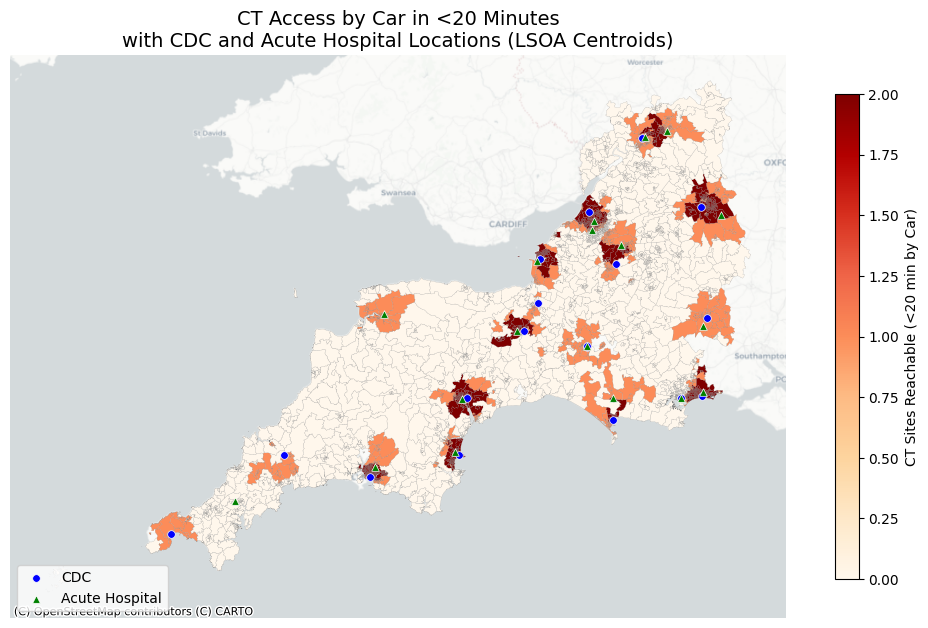

In [42]:
# ----------------------------------------------------------
# Step 6 – CT Access Choropleth with CDC + Acute Overlays (LSOA Centroids)
# ----------------------------------------------------------

# 6.1 – Extract base geometry and rebuild plotting GeoDataFrame
gdf_geom = gdf_lsoa[["lsoa21cd", "geometry"]].copy()

gdf_access = gdf_geom.merge(
    gdf_lsoa[["lsoa21cd", "ct_access_car_lt_20"]],
    on="lsoa21cd",
    how="left"
)

# 6.2 – Prepare facility GeoDataFrame from df_sites (already contains 'site_type')
facilities_df = df_sites.copy()
facilities_df = facilities_df.dropna(subset=["lsoa21cd"]).drop_duplicates()
facilities_df["lsoa21cd"] = facilities_df["lsoa21cd"].astype(str)

# Merge with LSOA geometry and convert to GeoDataFrame
facilities_gdf = facilities_df.merge(gdf_geom, on="lsoa21cd", how="left")
facilities_gdf = gpd.GeoDataFrame(facilities_gdf, geometry="geometry", crs=gdf_geom.crs)

# Use LSOA centroids for plotting
facilities_gdf["geometry"] = facilities_gdf["geometry"].centroid

# Split into CDC and Acute GeoDataFrames
cdc_gdf = facilities_gdf[facilities_gdf["site_type"] == "CDC"]
acute_gdf = facilities_gdf[facilities_gdf["site_type"] == "Acute"]

# 6.3 – Plot choropleth with facility overlays
fig, ax = plt.subplots(figsize=(10, 10))

# Base map: CT access per LSOA
gdf_access.plot(
    column="ct_access_car_lt_20",
    cmap="OrRd",
    linewidth=0.1,
    edgecolor="grey",
    legend=True,
    legend_kwds={"label": "CT Sites Reachable (<20 min by Car)", "shrink": 0.5},
    ax=ax
)

# Overlay CDCs: blue circles
cdc_gdf.plot(
    ax=ax,
    color="blue",
    markersize=30,
    marker="o",
    edgecolor="white",
    linewidth=0.5,
    label="CDC"
)

# Overlay Acute Hospitals: green triangles
acute_gdf.plot(
    ax=ax,
    color="green",
    markersize=30,
    marker="^",
    edgecolor="white",
    linewidth=0.5,
    label="Acute Hospital"
)

# Final formatting
ax.set_title("CT Access by Car in <20 Minutes\nwith CDC and Acute Hospital Locations (LSOA Centroids)", fontsize=14)
ax.axis("off")
ax.legend(loc="lower left", frameon=True)

# Basemap (optional)
ctx.add_basemap(ax, crs=gdf_access.crs.to_string(), source=ctx.providers.CartoDB.Positron)

plt.tight_layout()
plt.show()


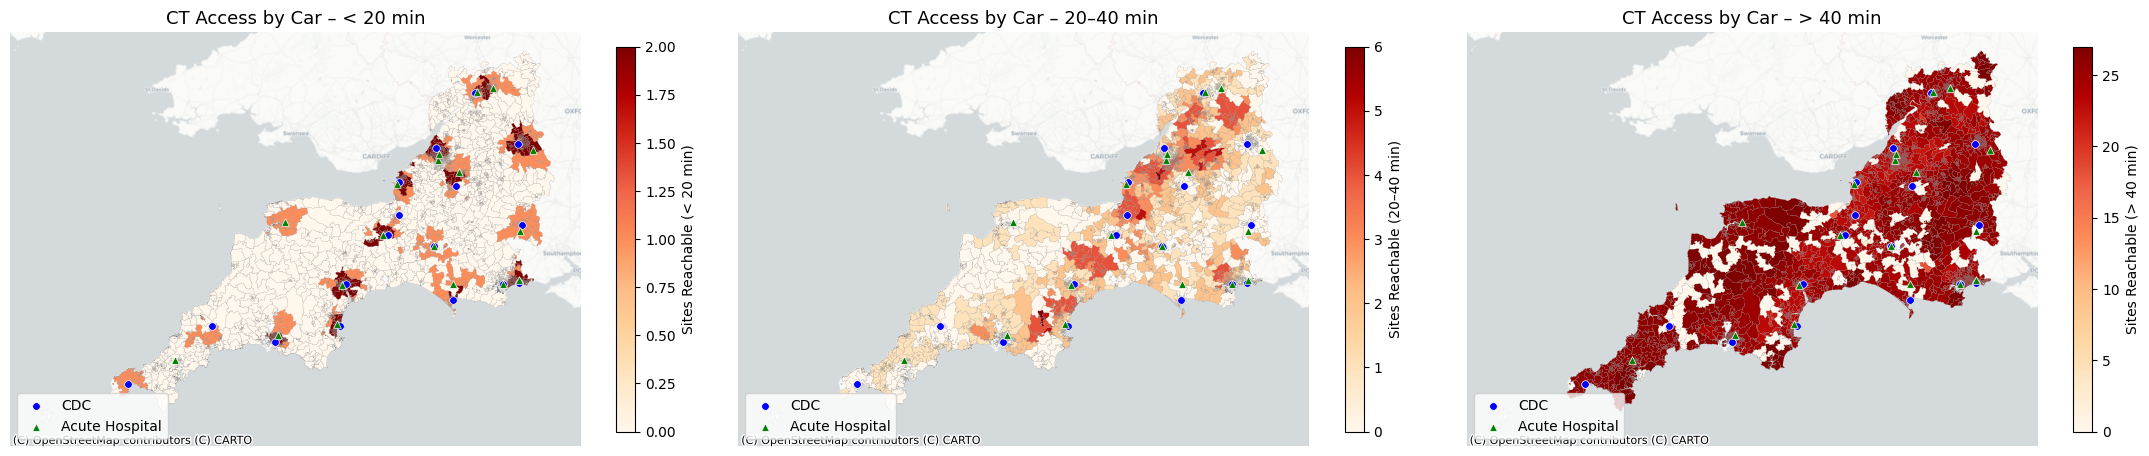

In [43]:
# ----------------------------------------------------------
# Step 6 – Multi-Panel Map: CT Access by Car (3 Travel Time Bands)
# ----------------------------------------------------------

# Set up labels for each band
access_cols = {
    'ct_access_car_lt_20': '< 20 min',
    'ct_access_car_20_40': '20–40 min',
    'ct_access_car_gt_40': '> 40 min'
}

# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(22, 8))

# Loop over each travel time band
for ax, (col, label) in zip(axes, access_cols.items()):
    
    # Merge geometry and access score
    gdf_access_band = gdf_lsoa[['lsoa21cd', 'geometry', col]].copy()

    # Base layer: LSOA access map
    gdf_access_band.plot(
        column=col,
        cmap='OrRd',
        linewidth=0.1,
        edgecolor='grey',
        legend=True,
        legend_kwds={"label": f"Sites Reachable ({label})", "shrink": 0.5},
        ax=ax
    )

    # Overlay CDCs: blue circles
    cdc_gdf.plot(
        ax=ax,
        color="blue",
        markersize=30,
        marker="o",
        edgecolor="white",
        linewidth=0.5,
        label="CDC"
    )

    # Overlay Acute Hospitals: green triangles
    acute_gdf.plot(
        ax=ax,
        color="green",
        markersize=30,
        marker="^",
        edgecolor="white",
        linewidth=0.5,
        label="Acute Hospital"
    )

    # Map formatting
    ax.set_title(f"CT Access by Car – {label}", fontsize=13)
    ax.axis("off")
    ax.legend(loc="lower left", frameon=True)

    # Add basemap
    ctx.add_basemap(ax, crs=gdf_lsoa.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Layout adjustments
plt.tight_layout()
plt.show()


In [45]:
# ----------------------------------------------------------
# Step 7 – Count LSOAs with Zero CT Access in Each Time Band
# ----------------------------------------------------------

# List of access columns and readable labels
access_cols = {
    'ct_access_car_lt_20': '< 20 min',
    'ct_access_car_20_40': '20–40 min',
    'ct_access_car_gt_40': '> 40 min'
}

# Loop through each band and report number of LSOAs with zero access
print("Number of LSOAs with 0 CT sites reachable by car in each band:\n")
for col, label in access_cols.items():
    zero_count = (gdf_lsoa[col] == 0).sum()
    print(f"  {label}: {zero_count} LSOAs")




Number of LSOAs with 0 CT sites reachable by car in each band:

  < 20 min: 1672 LSOAs
  20–40 min: 1054 LSOAs
  > 40 min: 84 LSOAs


Number of LSOAs with 0 CT access even at >40 mins: 84


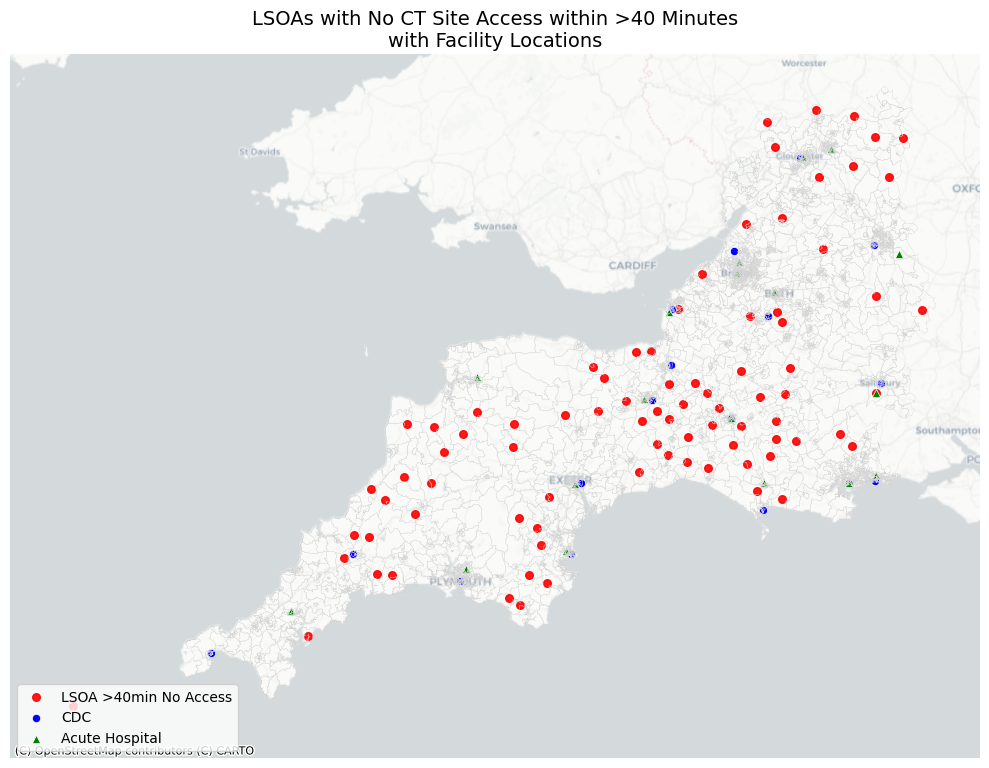

In [46]:
# ----------------------------------------------------------
# Step 9 – Visualise LSOAs with No CT Site Access in >40 mins
# ----------------------------------------------------------

# Filter LSOAs with 0 CT access even beyond 40 minutes
gdf_zero_gt40 = gdf_lsoa[gdf_lsoa['ct_access_car_gt_40'] == 0].copy()
print(f"Number of LSOAs with 0 CT access even at >40 mins: {gdf_zero_gt40.shape[0]}")

# Use centroids for plotting
gdf_zero_gt40['geometry'] = gdf_zero_gt40['geometry'].centroid

# Plot: Map with facility overlay
fig, ax = plt.subplots(figsize=(10, 10))

# Base layer: all LSOA outlines for context
gdf_lsoa.boundary.plot(ax=ax, color='lightgrey', linewidth=0.2)

# Plot underserved LSOAs as red dots
gdf_zero_gt40.plot(ax=ax, color='red', markersize=30, label='LSOA >40min No Access', alpha=0.9)

# Overlay CDCs (blue circles)
cdc_gdf.plot(
    ax=ax,
    color='blue',
    marker='o',
    markersize=35,
    edgecolor='white',
    linewidth=0.5,
    label='CDC'
)

# Overlay Acute Hospitals (green triangles)
acute_gdf.plot(
    ax=ax,
    color='green',
    marker='^',
    markersize=35,
    edgecolor='white',
    linewidth=0.5,
    label='Acute Hospital'
)

# Final formatting
ax.set_title("LSOAs with No CT Site Access within >40 Minutes\nwith Facility Locations", fontsize=14)
ax.axis('off')
ax.legend(loc='lower left')

# Add basemap
ctx.add_basemap(ax, crs=gdf_lsoa.crs.to_string(), source=ctx.providers.CartoDB.Positron)

plt.tight_layout()
plt.show()
